In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install nilearn

In [1]:
import nibabel as nib
import nilearn as nil
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [2]:
#os.listdir('/content/drive/My Drive/MICCAI_BraTS/2020/train/4D/combined')

In [3]:
sample = nib.load('/content/drive/My Drive/MICCAI_BraTS/2020/train/4D/combined/BraTS20_Training_071.nii.gz')
sample = sample.get_fdata()
sample.shape

(240, 240, 155, 4)

In [4]:
img = sample[:,:,0,:]
img.shape

(240, 240, 4)

In [5]:
mask_sample = nib.load('/content/drive/My Drive/MICCAI_BraTS/2020/train/4D/mask/BraTS20_Training_071.nii.gz')
mask_sample = mask_sample.get_fdata()
mask_sample.shape

(240, 240, 155)

In [6]:
def process_path(file_path):
    file_path = file_path.numpy().decode('utf-8')
    #print(file_path)
    sep = '/'
    mask = nib.load(file_path)
    mask = mask.get_fdata()
    #print(mask.shape)
    parts = file_path.split('/')
    parts[-2] = 'combined'
    img_path = sep.join(parts)
    img = nib.load(img_path)
    img = img.get_fdata()
    return img, mask

In [7]:
def get_images(file_path):
    img, mask = process_path(file_path)

    #print(img.shape)

    img = tf.convert_to_tensor(img/255, tf.float64)
    mask = tf.convert_to_tensor(mask)
    mask_wt = tf.logical_or(tf.logical_or(tf.equal(mask, 1), tf.equal(mask, 2)), tf.equal(mask, 4))
    mask_wt = tf.cast(mask_wt, tf.float64)
    #print(mask_wt.shape)
    mask_tc = tf.logical_or(tf.equal(mask, 1), tf.equal(mask, 4))
    mask_tc = tf.cast(mask_tc, tf.float64)
    mask_et =tf.equal(mask, 4)
    mask_et = tf.cast(mask_et, tf.float64)
    label = tf.stack([mask_wt, mask_tc, mask_et], axis=-1)
    return img, label

In [8]:
def get_images_wrapper(file_path):
    a, b = tf.py_function(get_images, [file_path], [tf.float64, tf.float64])
    return a, b

In [9]:
AUTO = tf.data.experimental.AUTOTUNE

In [10]:
train_data = tf.data.Dataset.list_files('/content/drive/My Drive/MICCAI_BraTS/2020/train/4D/mask/*')

In [12]:
train_data = train_data.map(get_images_wrapper).cache().batch(1).prefetch(buffer_size=AUTO)

In [13]:
c, d = next(iter(train_data))
c.shape, d.shape

(TensorShape([1, 240, 240, 155, 4]), TensorShape([1, 240, 240, 155, 3]))

In [14]:
def down_conv_vnet(input_mat, n_layers, reps):
    
    ip = input_mat

    for i in range(reps):
        c1 = Conv2D(n_layers, kernel_size=(5,5), strides=(1,1), padding='same')(ip)
        ip = PReLU()(c1)

    add1 = add([input_mat, ip])

    return ip   

In [15]:
def new_model_1():

    inputs = Input(shape=(32,32,4))
    c1 = Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='same')(inputs) # 32x32x16
    c1 = PReLU()(c1)                                                                                                          
    repeat1 = concatenate(4 * [inputs], axis=-1) # 32x32x16                                    
    add1 = add([c1, repeat1]) # 32x32x16

    down1 = Conv2D(32, kernel_size=(2,2), strides=(2,2))(add1) # 16x16x32                
    layer1 = PReLU()(down1) 

    add2 = down_conv_vnet(layer1, 32, 2) # 16x16x32                                                                           
    down2 = Conv2D(64, kernel_size=(2,2), strides=(2,2))(add2) # 8x8x64
    layer2 = PReLU()(down2)                                 

    add3 = down_conv_vnet(layer2, 64, 3) # 8x8x64
    down3 = Conv2D(128, kernel_size=(2,2), strides=(2,2))(add3) # 4x4x128
    layer3 = PReLU()(down3)

    add4 = down_conv_vnet(layer3, 128, 3) # 4x4x128
    
    # segmentation output
    up1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2))(add4) # 8x8x64
    layer4 = PReLU()(up1)

    add5 = down_conv_vnet(concatenate([layer4, add3]), 128, 3) # 8x8x128
    up2 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2))(add5) # 16x16x32
    layer5 = PReLU()(up2)
    
    add6 = down_conv_vnet(concatenate([layer5, add2]), 64, 2) # 16x16x64
    up3 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2))(add6) # 32x32x16
    layer6 = PReLU()(up3)

    add7 = down_conv_vnet(concatenate([layer6, add1]), 32, 1) # 32x32x32

    c2 = Conv2D(3, kernel_size=(1,1), strides=(1,1))(add7)
    seg_out = Softmax(name='seg_out')(c2)

    #autoencoder output
    up4 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2))(add4) # 8x8x64
    layer7 = PReLU()(up4)

    add8 = down_conv_vnet(layer7, 64, 3) # 8x8x64
    up5 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2))(add8) # 16x16x32
    layer8 = PReLU()(up5)
    
    add9 = down_conv_vnet(layer8, 32, 2) # 16x16x32
    up6 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2))(add9) # 32x32x16
    layer9 = PReLU()(up6)

    add10 = down_conv_vnet(layer9, 16, 1) # 32x32x16

    c3 = Conv2D(4, kernel_size=(1,1), strides=(1,1))(add10)
    vae_out = Softmax(name='vae_out')(c3)

    model = Model(inputs=inputs, outputs=[seg_out, vae_out])
    return model

In [16]:
new_model = new_model_1()

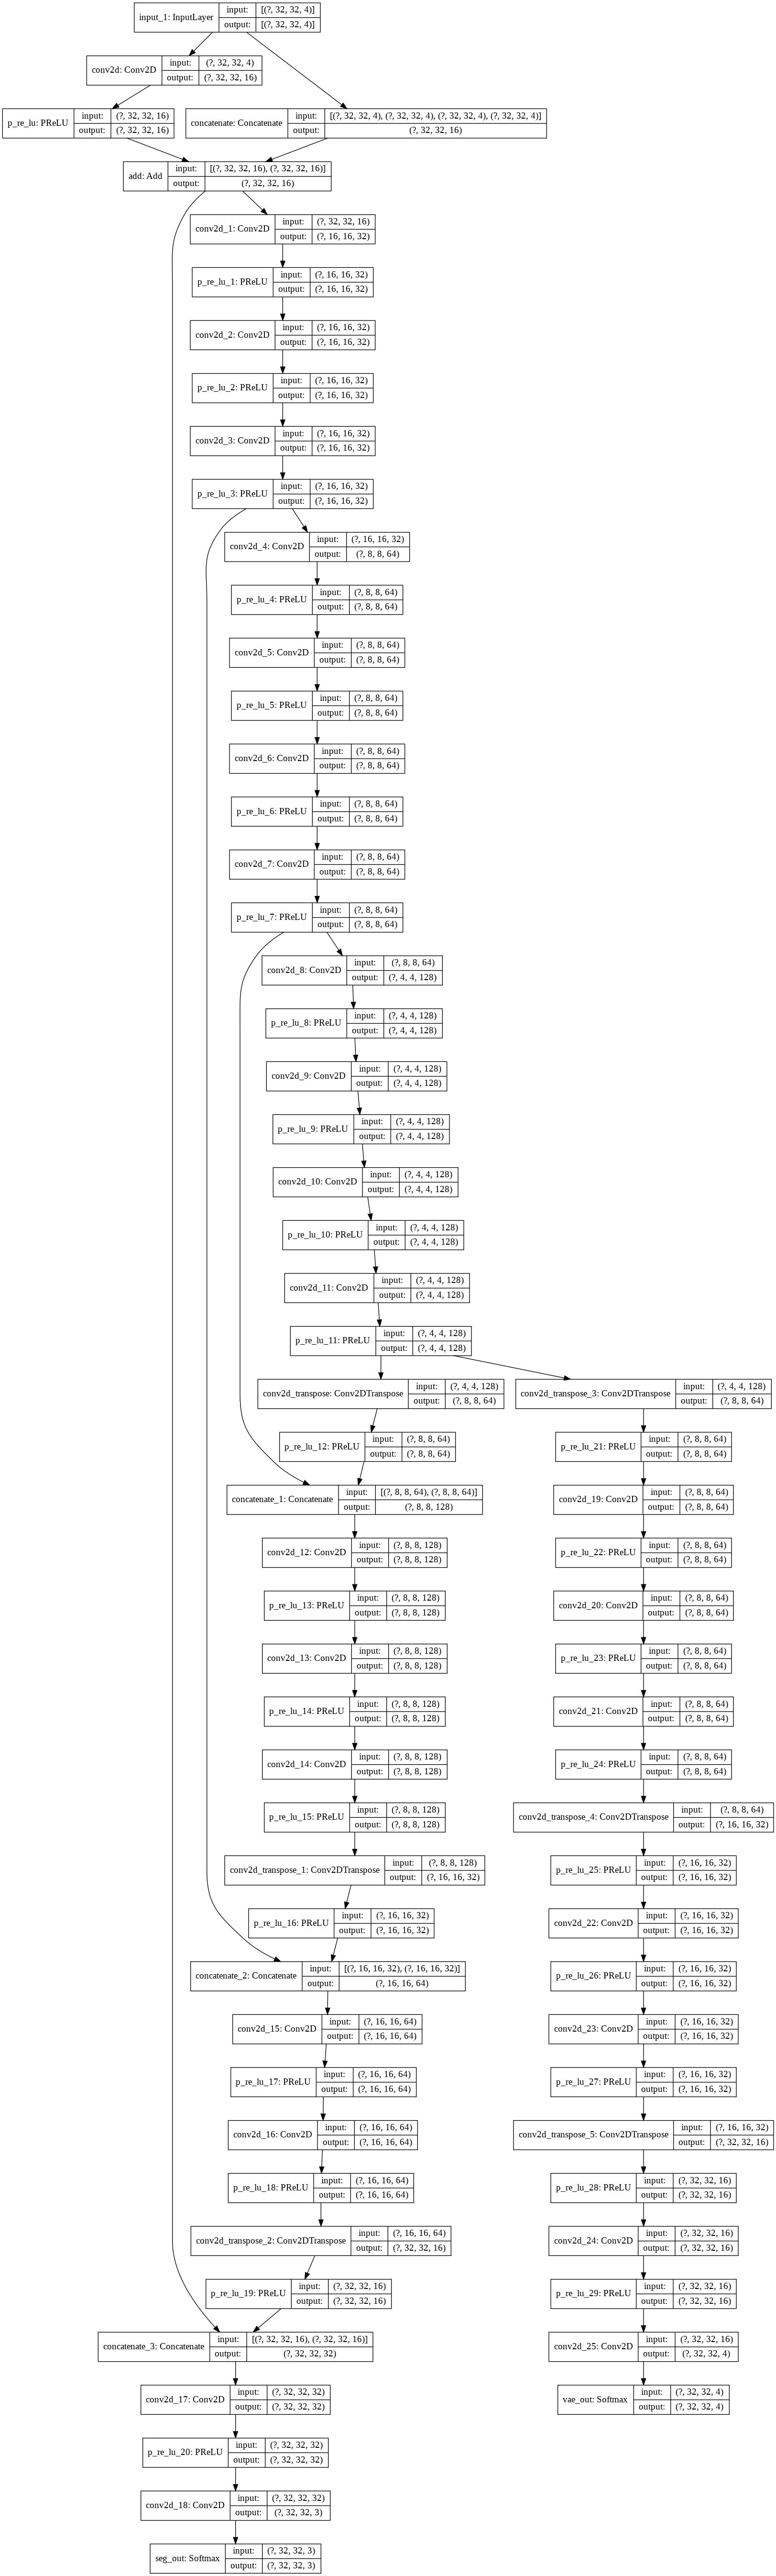

In [17]:
tf.keras.utils.plot_model(new_model, show_shapes=True)

In [18]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 3
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [19]:
def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

In [20]:
losses_array = {}
metrics_array = {}

losses_array['seg_out'] = dice_coef_loss
losses_array['vae_out'] = 'mse'

metrics_array['seg_out'] = dice_coef
metrics_array['vae_out'] = 'mse'

In [21]:
new_model.compile(optimizer=Adam(lr=1e-4), loss=losses_array, metrics=metrics_array)

In [22]:
EPOCHS = 1

In [ ]:
for epoch in range(EPOCHS):
    for (img, mask) in train_data:
        
        # get 2D slices for each image in the batch
        img_slices = []
        mask_slices = []
        for img_no in range(img.shape[0]): 
            for slice_no in range(img.shape[3]):
                img_slices.append(img[img_no,:,:,slice_no,:])
                mask_slices.append(mask[img_no,:,:,slice_no,:])
        img_slices = tf.convert_to_tensor(img_slices)
        mask_slices = tf.convert_to_tensor(mask_slices)

        # get patches of required shape from 2D slices
        img_patches = tf.image.extract_patches(images=img_slices,
                           sizes=[1, 32, 32, 1],
                           strides=[1, 32, 32, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME')

        mask_patches = tf.image.extract_patches(images=mask_slices,
                           sizes=[1, 32, 32, 1],
                           strides=[1, 32, 32, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME')
        
        # extract each patch and reshape into required form
        patch_batch = []
        mask_patch_batch = []
        for b in range(img_patches.shape[0]):
            for patch_row in range(img_patches.shape[1]):
                for patch_col in range(img_patches.shape[2]):
                    img_patch = img_patches[b, patch_row, patch_col]
                    img_patch = tf.reshape(img_patch, (32,32,4))
                    patch_batch.append(img_patch)
                    mask_patch = mask_patches[b, patch_row, patch_col]
                    mask_patch = tf.reshape(mask_patch, (32,32,3))
                    mask_patch_batch.append(mask_patch)
        #patch_batch = tf.convert_to_tensor(patch_batch)
        #mask_patch_batch = tf.convert_to_tensor(mask_patch_batch)

        no_mini_batches = 155
        start = 0
        step = len(patch_batch)//no_mini_batches
        end = start + step
        
        for mini_batch in range(no_mini_batches):

            print('Batch : ', (mini_batch+1),'/',no_mini_batches)

            patch_mini = patch_batch[start:end]
            mask_mini = mask_patch_batch[start:end]

            patch_mini = tf.convert_to_tensor(patch_mini)
            mask_mini = tf.convert_to_tensor(mask_mini)
            #print(patch_mini.shape)
            #print(mask_mini.shape)

            new_model.fit(x=patch_mini, y={'seg_out':mask_mini, 'vae_out':patch_mini})

            start += step
            end += step

Batch :  1 / 155
2/2 [==============================] - 0s 16ms/step - loss: 1.0624 - seg_out_loss: 0.9999 - vae_out_loss: 0.0625 - seg_out_dice_coef: 9.1544e-05 - vae_out_mse: 0.0625
Batch :  2 / 155
2/2 [==============================] - 0s 14ms/step - loss: 1.0624 - seg_out_loss: 0.9999 - vae_out_loss: 0.0625 - seg_out_dice_coef: 9.1544e-05 - vae_out_mse: 0.0625
Batch :  3 / 155
2/2 [==============================] - 0s 15ms/step - loss: 1.0624 - seg_out_loss: 0.9999 - vae_out_loss: 0.0625 - seg_out_dice_coef: 9.1544e-05 - vae_out_mse: 0.0625
Batch :  4 / 155
2/2 [==============================] - 0s 14ms/step - loss: 1.0624 - seg_out_loss: 0.9999 - vae_out_loss: 0.0625 - seg_out_dice_coef: 9.1544e-05 - vae_out_mse: 0.0625
Batch :  5 / 155
2/2 [==============================] - 0s 14ms/step - loss: 1.0625 - seg_out_loss: 0.9999 - vae_out_loss: 0.0626 - seg_out_dice_coef: 9.1544e-05 - vae_out_mse: 0.0626
Batch :  6 / 155
2/2 [==============================] - 0s 14ms/step - loss: 1.0